In [1]:
# 데이터 전처리부분 #! 할것! 멜 노말라이즈

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
from librosa.filters import mel as librosa_mel_fn # 멜 생성
import soundfile as sf

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
import torchaudio
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import io
from PIL import Image
from tqdm import tqdm
from glob import glob

device = "cuda:0" if torch.cuda.is_available() else "cpu"
vocoder = torch.hub.load('descriptinc/melgan-neurips', 'load_melgan')

def load_pickle_file(fileName):
    with open(fileName, 'rb') as f:
        return pickle.load(f)
        
def save_pickle_file(variable, fileName):
    with open(fileName, 'wb') as f:
        pickle.dump(variable, f)





            #############################################################
            #################                           #################
            #############################################################



def wave2mel_melgan(wavspath, SAMPLING_RATE=22050): #! 아직 노말라이징은 없음
    wav_files = glob(os.path.join(
        wavspath, '**', '*.wav'), recursive=True)
    
    wav_files = sorted(wav_files)

    print(len(wav_files))
    print(wav_files)

    mel_list = []

    for wav_path in tqdm(wav_files, desc='Preprocessing wav to mel (MelGAN)'): 
        wave_ori, _ = librosa.load(wav_path, sr=SAMPLING_RATE, mono=True)
        
        spectrogram = vocoder(torch.tensor([wave_ori])) 
        mel_list.append(spectrogram.cpu().detach().numpy()[0])
        # print(len(mel_list))

    mel_concatenated = np.concatenate(mel_list, axis=1)
    #! normlized needed
    return mel_concatenated



def wave2mel_librosa(wavspath, SAMPLING_RATE=22050): #! 아직 노말라이징은 없음
    wav_files = glob(os.path.join(
        wavspath, '**', '*.wav'), recursive=True)
    
    wav_files = sorted(wav_files)

    print(len(wav_files))
    print(wav_files)

    mel_list = []

    for wav_path in tqdm(wav_files, desc='Preprocessing wav to mel'): 
        wave_ori, _ = librosa.load(wav_path, sr=SAMPLING_RATE, mono=True)
        
        spectrogram = librosa.feature.melspectrogram(y=wave_ori, n_fft=1024, n_mels=80, sr=22050, hop_length=256, win_length=1024, fmax=8000, fmin=0, center=False)
        mel_list.append(spectrogram)
        # print(len(mel_list))

    mel_concatenated = np.concatenate(mel_list, axis=1)
    #! normlized needed
    return mel_concatenated



def preprocess_dataset_melgan(data_path, speaker_id, cache_folder):

    """Preprocesses dataset of .wav files by converting to Mel-spectrograms.
    Args:
        data_path (str): Directory containing .wav files of the speaker.
        speaker_id (str): ID of the speaker.
        cache_folder (str, optional): Directory to hold preprocessed data.
    """

    print(f"Preprocessing data for speaker: {speaker_id}.")

    mel_concat = wave2mel_melgan(data_path)

    if not os.path.exists(os.path.join(cache_folder, speaker_id)):
        os.makedirs(os.path.join(cache_folder, speaker_id))
    
    save_pickle_file(variable = mel_concat, fileName = os.path.join(cache_folder, f"{speaker_id}_normalized_full.pickle")) #! 800개 한번에 붙일때

    print(f"Preprocessed and saved data for the speaker: {speaker_id}.")
    

def preprocess_dataset_librosa(data_path, speaker_id, cache_folder):

    """Preprocesses dataset of .wav files by converting to Mel-spectrograms.
    Args:
        data_path (str): Directory containing .wav files of the speaker.
        speaker_id (str): ID of the speaker.
        cache_folder (str, optional): Directory to hold preprocessed data.
    """

    print(f"Preprocessing data for speaker: {speaker_id}.")

    mel_concat = wave2mel_librosa(data_path)

    if not os.path.exists(os.path.join(cache_folder, speaker_id)):
        os.makedirs(os.path.join(cache_folder, speaker_id))
    
    save_pickle_file(variable = mel_concat, fileName = os.path.join(cache_folder, f"{speaker_id}_normalized_full.pickle")) #! 800개 한번에 붙일때

    print(f"Preprocessed and saved data for the speaker: {speaker_id}.")


# 각각저장된 멜 확인


def get_mel_spectrogram_fig_melgan(spec, title="Mel-Spectrogram"):
    """Generates a figure of the Mel-spectrogram and converts it to a tensor.

    Args:
        spec (torch.Tensor): Mel-spectrogram
        title (str, optional): Figure name. Defaults to "Mel-Spectrogram".

    Returns:
        torch.Tensor: Figure as tensor
    """
    figure, ax = plt.subplots()
    canvas = FigureCanvas(figure)
    S_db = librosa.power_to_db(10**spec.squeeze(), ref=np.max)
    img = librosa.display.specshow(S_db, ax=ax, y_axis='log', x_axis='time')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
        
    image = Image.open(buf)
    image = ToTensor()(image)
    
    plt.close(figure)
    return image



def get_mel_spectrogram_fig_librosa(spec, title="Mel-Spectrogram"):
    """Generates a figure of the Mel-spectrogram and converts it to a tensor.

    Args:
        spec (torch.Tensor): Mel-spectrogram
        title (str, optional): Figure name. Defaults to "Mel-Spectrogram".

    Returns:
        torch.Tensor: Figure as tensor
    """
    fig, ax = plt.subplots()
    M = spec
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
    ax.set(title='Mel spectrogram display')
    fig.colorbar(img, ax=ax, format="%+2.f dB")


def ndarray_statistics(x):
    print(f"sum: {x.sum()}")
    print(f"mean: {x.mean()}")
    print(f"standard deviation: {x.std()}")
    print(f"variance: {x.var()}")
    print(f"min: {x.min()}")
    print(f"max: {x.max()}")

Using cache found in /home/yuholee/.cache/torch/hub/descriptinc_melgan-neurips_master
/home/yuholee/.cache/torch/hub/descriptinc_melgan-neurips_master/mel2wav/modules.py:42: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=None as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


# Librosa trim


In [ ]:
def remove_silence(x, y, speaker_id):
    file_list = glob(f"{x}/*")
    idx = 1
    print(file_list)
    for i in tqdm(file_list):
        wave_ori, _ = librosa.load(f"{i}", sr=22050, mono=True)
        yt, _ = librosa.effects.trim(wave_ori, top_db=30)
        torchaudio.save(y + "/" + speaker_id + "_" + f"{idx}.wav", torch.tensor([yt]), sample_rate=22050)
        idx += 1

In [ ]:
source_path = "/home/yuholee/develop/data_KR/eval/A_F_02_e"
save_path = "/home/yuholee/develop/data_KR_trim/eval/A_F_02_e"
spk_id = "A_F_02_e"

remove_silence(source_path, save_path, spk_id)

# Full_pickle 만들기

In [ ]:
source_dir = "/home/yuholee/develop/data_KR_trim/eval/B_M_14_e"
spk_id = "B_M_14_e"
save_dir = "/home/yuholee/develop/data_KR_full_melgan/eval_mel/B_M_14_e"

preprocess_dataset_melgan(source_dir, spk_id, save_dir)

In [ ]:
# 멜 확인해보기
sample_mel = load_pickle_file("/home/yuholee/develop/data_KR_full_melgan/eval_mel/B_M_14_e/B_M_14_e_normalized_full.pickle")
print(sample_mel.shape)

mel = get_mel_spectrogram_fig_melgan(sample_mel) # a: (C, H, W)
mel = mel.permute(1,2,0)  # a: (H, W, C)
print(mel.size())
plt.imshow(mel)

# 이어진 멜파일을 80간격으로 쪼개서 저장하기


In [ ]:
def mel_80(load_folder, save_folder, speaker_id):
    full_mel = load_pickle_file((f"{load_folder}"))

    idx = 1
    num1 = 0
    num2 = 80

    while num2 < full_mel[1].shape[0]: #80 단위별로 끊기
        print(f"index{idx}")

        if not os.path.exists(os.path.join(save_folder, speaker_id)):
            os.makedirs(os.path.join(save_folder, speaker_id))

        save_pickle_file(variable=full_mel[:, num1:num2],
                    fileName=os.path.join(save_folder, f"{speaker_id}_{idx}_normalized.pickle"))

        num1 += 81
        num2 += 81
        idx += 1


load_f = "/home/yuholee/develop/data_KR_full_melgan/eval_mel/A_F_02_e/A_F_02_e_normalized_full.pickle"
save_f = "/home/yuholee/develop/data_KR_80_melgan/eval/A_F_02_e"
spk_id = "A_F_02_e"

mel_80(load_f, save_f, spk_id)


### 80단위로 자른데이터 .wav로 확인해보기


In [ ]:
def mel_to_wav(source_path):
    spec_check = load_pickle_file(f"{source_path}")
    spec_check_tensor = torch.tensor([spec_check])
    spec_check_return = vocoder.inverse(spec_check_tensor[0].detach().cpu())
    spec_check_return = spec_check_return.cpu()

    torchaudio.save("/home/yuholee/develop/check_rev_aduio_sample.wav", spec_check_return, sample_rate=22050)


source_file = "/home/yuholee/develop/data_KR_80_melgan/train/A_F_02_t/A_F_02_t_18_normalized.pickle"

mel_to_wav(source_file)

(80, 142637)
torch.Size([288, 432, 3])
sum: -30205468.0
mean: -2.64705753326416
standard deviation: 1.1790498495101929
variance: 1.3901585340499878
min: -5.0
max: 0.5537829399108887


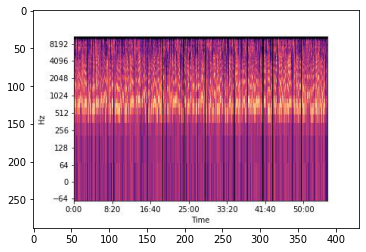

In [6]:
# 멜 확인해보기
sample_mel = load_pickle_file("/home/yuholee/develop/data_KR_full_melgan/train_mel/A_F_02_t/A_F_02_t_normalized_full.pickle")
print(sample_mel.shape)

mel = get_mel_spectrogram_fig_melgan(sample_mel)
mel = mel.permute(1,2,0) 
print(mel.size())
plt.imshow(mel)

ndarray_statistics(sample_mel)

### 그냥 원래음성 보코더 -> 음성합성 해보기

In [5]:
wave_ori, _ = librosa.load("/home/yuholee/develop/data_KR/eval/A_F_02_e/A_F_02_e_1.wav", sr=22050, mono=True)

spec1 = vocoder(torch.tensor([wave_ori])) 
spec1 = spec1.cpu()

print(type(spec1))
print(spec1.shape)
print(spec1[0].shape)
spec_return1 = vocoder.inverse(spec1[0].detach().cpu())
spec_return1 = spec_return1.cpu()

torchaudio.save("/home/yuholee/develop/ViTCycleGAN/original_aduio_sample.wav", spec_return1, sample_rate=22050)

/tmp/ipykernel_17529/3467297515.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  spec1 = vocoder(torch.tensor([wave_ori]))


<class 'torch.Tensor'>
torch.Size([1, 80, 170])
torch.Size([80, 170])


/home/yuholee/.conda/envs/Test/lib/python3.9/site-packages/torch/functional.py:695: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/SpectralOps.cpp:798.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


# 학습된 멜 확인 (멜그리기, 음성변환)

<class 'torch.Tensor'>
torch.Size([8, 1, 80, 80])
torch.Size([288, 432, 3])
<class 'torch.Tensor'>
torch.Size([8, 80, 80])
torch.Size([80, 80])


/tmp/ipykernel_17529/1966993157.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  converted_mel = torch.tensor(converted_mel).to(device).float()


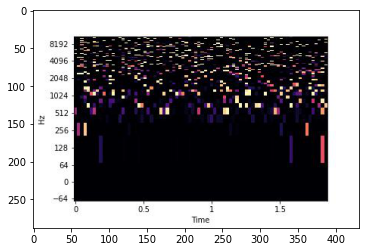

In [11]:
# 변환된 mel피클파일 넣기

converted_mel = load_pickle_file("/home/yuholee/develop/ViTCycleGAN/saved_mels/75_mel_x.pickle")

print(type(converted_mel))
print(converted_mel.shape)

converted_mel = torch.tensor(converted_mel).to(device).float()
converted_mel = converted_mel.squeeze(1)


            ##############################################
            #################    멜그리기 ################
            ##############################################

mel_conv_temp = get_mel_spectrogram_fig(converted_mel.cpu()[0].squeeze()) # a: (C, H, W) -> 스퀴즈해서 (80, 80으로)
# mel = get_mel_spectrogram_fig(original_mel)
mel = mel_conv_temp.permute(1,2,0)  # a: (H, W, C)
print(mel.size())
plt.imshow(mel)

print(type(converted_mel))
print(converted_mel.shape)
print(converted_mel[0].shape)

            ##############################################
            ############### 멜 오디오변환 #################
            ##############################################

spec_return = vocoder.inverse(converted_mel[0].detach().cpu())
spec_return = spec_return.cpu()

torchaudio.save("/home/yuholee/develop/ViTCycleGAN/result_aduio.wav", spec_return, sample_rate=22050)

# 다양한 테스트


### 1. Librsoa only (Waveform: librosa, mel: librosa)

sum: 2889.801025390625
mean: 0.21630246937274933
standard deviation: 1.8183194398880005
variance: 3.3062856197357178
min: 0.0
max: 45.14037322998047


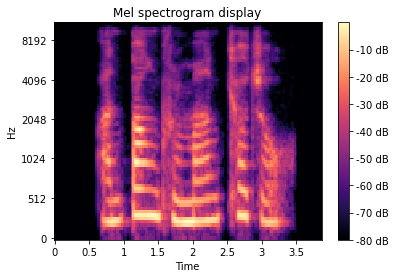

In [10]:
wav_file = "/home/yuholee/develop/ViTCycleGAN/test_sample.wav"

test_wave1, _ = librosa.load(wav_file, sr=22050, mono=True)

librosa_mel_test1 = librosa.feature.melspectrogram(y=test_wave1, n_fft=1024, n_mels=80, sr=22050, hop_length=256, win_length=1024, fmax=8000, fmin=0, center=False) 


fig, ax = plt.subplots()
M = librosa_mel_test1
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")

ndarray_statistics(librosa_mel_test1)


### 2. Librosa + MelGAN (Waveform: librosa, mel: MelGAN)

In [22]:
melgan_mel_test1 = vocoder(torch.tensor([test_wave1])) 
# melgan_mel_test1 = melgan_mel_test1.cpu()
# melgan_mel_test1 = melgan_mel_test1.squeeze()
# melgan_mel_test1 = melgan_mel_test1.numpy()


# fig, ax = plt.subplots()
# M = melgan_mel_test1
# M_db = librosa.power_to_db(M, ref=np.max)
# img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
# ax.set(title='Mel spectrogram display')
# fig.colorbar(img, ax=ax, format="%+2.f dB")

# ndarray_statistics(melgan_mel_test1)

torch.Size([288, 432, 3])


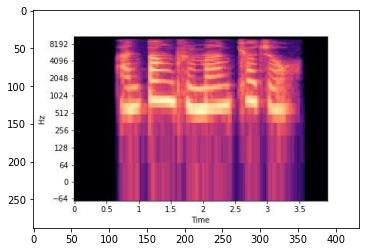

In [21]:
mel_conv_temp = get_mel_spectrogram_fig(melgan_mel_test1) 
# mel = get_mel_spectrogram_fig(original_mel)
mel = mel_conv_temp.permute(1,2,0)  
plt.imshow(mel)